In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
flights = pd.read_csv('nycflights.csv', dtype = {'dep_time' : object, 
                                                 'dep_delay': object, 
                                                 'arr_time' : object, 
                                                 'arr_delay': object, 
                                                 'air_time' : object})
flights['date'] = pd.to_datetime({'year':flights.year, 'month':flights.month, 'day':flights.day})
def convert_time(column_name):
    the_min = flights[column_name][ flights[column_name].notnull() ].astype(str).str[-2:  ]
    the_hr  = flights[column_name][ flights[column_name].notnull() ].astype(str).str[  :-2]
    date_time = pd.to_datetime({'year':flights.year, 'month':flights.month, 'day':flights.day, 
                                'hour': the_hr, 'minute': the_min})
    # the magic of indexes allow us to combine flights.year which has all the rows
    # and the_hr which only exists for rows where dep_time is not NaN
    return date_time
dep_date_time       = convert_time('dep_time')
sched_dep_date_time = convert_time('sched_dep_time')
arr_date_time       = convert_time('arr_time')
sched_arr_date_time = convert_time('sched_arr_time')

datetimes = pd.concat({'dep_date_time': dep_date_time,
           'sched_dep_date_time': sched_dep_date_time, 
           'arr_date_time':arr_date_time, 
           'sched_arr_date_time':sched_arr_date_time}, axis = 1)
flights = flights.join(datetimes)  # we use the .join() function

### A Few Exercises

In [3]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 24 columns):
year                   336776 non-null int64
month                  336776 non-null int64
day                    336776 non-null int64
dep_time               328521 non-null object
sched_dep_time         336776 non-null int64
dep_delay              328521 non-null object
arr_time               328063 non-null object
sched_arr_time         336776 non-null int64
arr_delay              327346 non-null object
carrier                336776 non-null object
flight                 336776 non-null int64
tailnum                334264 non-null object
origin                 336776 non-null object
dest                   336776 non-null object
air_time               327346 non-null object
distance               336776 non-null int64
hour                   336776 non-null int64
minute                 336776 non-null int64
time_hour              336776 non-null object
date                   3

In [4]:
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,air_time,distance,hour,minute,time_hour,date,dep_date_time,sched_dep_date_time,arr_date_time,sched_arr_date_time
0,2013,1,1,517,515,2,830,819,11,UA,...,227,1400,5,15,1/1/2013 5:00,2013-01-01,2013-01-01 05:17:00,2013-01-01 05:15:00,2013-01-01 08:30:00,2013-01-01 08:19:00
1,2013,1,1,533,529,4,850,830,20,UA,...,227,1416,5,29,1/1/2013 5:00,2013-01-01,2013-01-01 05:33:00,2013-01-01 05:29:00,2013-01-01 08:50:00,2013-01-01 08:30:00
2,2013,1,1,542,540,2,923,850,33,AA,...,160,1089,5,40,1/1/2013 5:00,2013-01-01,2013-01-01 05:42:00,2013-01-01 05:40:00,2013-01-01 09:23:00,2013-01-01 08:50:00
3,2013,1,1,544,545,-1,1004,1022,-18,B6,...,183,1576,5,45,1/1/2013 5:00,2013-01-01,2013-01-01 05:44:00,2013-01-01 05:45:00,2013-01-01 10:04:00,2013-01-01 10:22:00
4,2013,1,1,554,600,-6,812,837,-25,DL,...,116,762,6,0,1/1/2013 6:00,2013-01-01,2013-01-01 05:54:00,2013-01-01 06:00:00,2013-01-01 08:12:00,2013-01-01 08:37:00


Find all flights that
- Had an arrival delay of two or more hours

In [5]:
flights.loc[flights.arr_delay.astype(float) > 120].shape

(10034, 24)

In [6]:
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,air_time,distance,hour,minute,time_hour,date,dep_date_time,sched_dep_date_time,arr_date_time,sched_arr_date_time
0,2013,1,1,517,515,2,830,819,11,UA,...,227,1400,5,15,1/1/2013 5:00,2013-01-01,2013-01-01 05:17:00,2013-01-01 05:15:00,2013-01-01 08:30:00,2013-01-01 08:19:00
1,2013,1,1,533,529,4,850,830,20,UA,...,227,1416,5,29,1/1/2013 5:00,2013-01-01,2013-01-01 05:33:00,2013-01-01 05:29:00,2013-01-01 08:50:00,2013-01-01 08:30:00
2,2013,1,1,542,540,2,923,850,33,AA,...,160,1089,5,40,1/1/2013 5:00,2013-01-01,2013-01-01 05:42:00,2013-01-01 05:40:00,2013-01-01 09:23:00,2013-01-01 08:50:00
3,2013,1,1,544,545,-1,1004,1022,-18,B6,...,183,1576,5,45,1/1/2013 5:00,2013-01-01,2013-01-01 05:44:00,2013-01-01 05:45:00,2013-01-01 10:04:00,2013-01-01 10:22:00
4,2013,1,1,554,600,-6,812,837,-25,DL,...,116,762,6,0,1/1/2013 6:00,2013-01-01,2013-01-01 05:54:00,2013-01-01 06:00:00,2013-01-01 08:12:00,2013-01-01 08:37:00


In [7]:
(flights.arr_date_time - flights.sched_arr_date_time)

0                 00:11:00
1                 00:20:00
2                 00:33:00
3        -1 days +23:42:00
4        -1 days +23:35:00
                ...       
336771                 NaT
336772                 NaT
336773                 NaT
336774                 NaT
336775                 NaT
Length: 336776, dtype: timedelta64[ns]

In [8]:
(flights.arr_date_time - flights.sched_arr_date_time) > pd.Timedelta(120, 'm')

0         False
1         False
2         False
3         False
4         False
          ...  
336771    False
336772    False
336773    False
336774    False
336775    False
Length: 336776, dtype: bool

In [9]:
# must use timedelta for comparisons between time amounts 
flights.loc[ (flights.arr_date_time - flights.sched_arr_date_time) > pd.Timedelta(120, 'm') ].shape

(7474, 24)

### There is significant mismatch between these two results.

Let's explore what could be wrong.

In [10]:
a = flights.loc[flights.arr_delay.astype(float) > 120].index

In [11]:
b = flights.loc[ (flights.arr_date_time - flights.sched_arr_date_time) > pd.Timedelta(120, 'm') ].index

In [12]:
a

Int64Index([   119,    151,    218,    268,    447,    470,    498,    512,
               609,    639,
            ...
            335778, 335986, 336207, 336252, 336529, 336579, 336668, 336724,
            336757, 336763],
           dtype='int64', length=10034)

In [13]:
a.difference(b)

Int64Index([   151,    815,    830,    834,    843,   1755,   1762,   1786,
              2682,   2700,
            ...
            327616, 327644, 329260, 332163, 332176, 333175, 335773, 335777,
            335778, 336763],
           dtype='int64', length=2979)

In [14]:
flights.loc[151]

year                                  2013
month                                    1
day                                      1
dep_time                               848
sched_dep_time                        1835
dep_delay                              853
arr_time                              1001
sched_arr_time                        1950
arr_delay                              851
carrier                                 MQ
flight                                3944
tailnum                             N942MQ
origin                                 JFK
dest                                   BWI
air_time                                41
distance                               184
hour                                    18
minute                                  35
time_hour                   1/1/2013 18:00
date                   2013-01-01 00:00:00
dep_date_time          2013-01-01 08:48:00
sched_dep_date_time    2013-01-01 18:35:00
arr_date_time          2013-01-01 10:01:00
sched_arr_d

the flight departed the next day, and the full date-time column doesn't reflect this


In [15]:
flights.loc[10455,]

year                                  2013
month                                    1
day                                     13
dep_time                                10
sched_dep_time                        2135
dep_delay                              155
arr_time                               305
sched_arr_time                          36
arr_delay                              149
carrier                                 B6
flight                                  11
tailnum                             N595JB
origin                                 JFK
dest                                   FLL
air_time                               144
distance                              1069
hour                                    21
minute                                  35
time_hour                  1/13/2013 21:00
date                   2013-01-13 00:00:00
dep_date_time                          NaT
sched_dep_date_time    2013-01-13 21:35:00
arr_date_time          2013-01-13 03:05:00
sched_arr_d

I also found this flight, where the csv file says the departure time is '10'.

It should have read 00:10, as in 12:10AM, but maybe limitations of the csv export dropped the leading 0s.

In [16]:
a = np.array(['a','','c','d'])
a

array(['a', '', 'c', 'd'], dtype='<U1')

In [17]:
np.where(a == '', '100', a)

array(['a', '100', 'c', 'd'], dtype='<U3')

In [18]:
flights = pd.read_csv('nycflights.csv', dtype = {'dep_time' : object,  
                                                 'arr_time' : object, 
                                                 'air_time' : object})
flights['date'] = pd.to_datetime({'year':flights.year, 'month':flights.month, 'day':flights.day})

def convert_time(column_name):
    the_min = flights[column_name][ flights[column_name].notnull() ].astype(str).str[-2:  ]
    the_hr  = flights[column_name][ flights[column_name].notnull() ].astype(str).str[  :-2]
    
    # this following line says that if the hr extracted from strings is empty, '', 
    # then replace it with 00, otherwise, use the hr that appears, and preserve the index
    the_hr  = pd.Series( np.where(the_hr == '', '00',the_hr) , index = the_hr.index)
    
    date_time = pd.to_datetime({'year':flights.year, 'month':flights.month, 'day':flights.day, 
                                'hour': the_hr, 'minute': the_min})
    return date_time

sched_dep_date_time = convert_time('sched_dep_time')
sched_arr_date_time = convert_time('sched_arr_time')

dep_date_time       = sched_dep_date_time + pd.to_timedelta(flights.dep_delay, 'm')
arr_date_time       = sched_arr_date_time + pd.to_timedelta(flights.arr_delay, 'm')

# clean up
# if a flight lands on the following day, we need to update that as well
# this shows that if the arr_date is before the dep_date, add 24 hours to the arrival times
sched_arr_date_time = pd.Series( np.where(sched_arr_date_time < sched_dep_date_time, 
                                          sched_arr_date_time + pd.Timedelta(24, 'h'), 
                                          sched_arr_date_time
                                         ) , index = sched_arr_date_time.index)
arr_date_time = pd.Series( np.where(arr_date_time < dep_date_time,
                                    arr_date_time + pd.Timedelta(24, 'h'),
                                    arr_date_time) , index = arr_date_time.index)

datetimes = pd.concat({'dep_date_time': dep_date_time,
           'sched_dep_date_time': sched_dep_date_time, 
           'arr_date_time':arr_date_time, 
           'sched_arr_date_time':sched_arr_date_time}, axis = 1)
flights = flights.join(datetimes)  # we use the .join() function
flights = flights.drop(['year','month','day'], axis = 1)
airlines = pd.read_csv('airlines.csv', index_col = 'carrier')

In [19]:
flights.loc[151,]

dep_time                               848
sched_dep_time                        1835
dep_delay                              853
arr_time                              1001
sched_arr_time                        1950
arr_delay                              851
carrier                                 MQ
flight                                3944
tailnum                             N942MQ
origin                                 JFK
dest                                   BWI
air_time                                41
distance                               184
hour                                    18
minute                                  35
time_hour                   1/1/2013 18:00
date                   2013-01-01 00:00:00
dep_date_time          2013-01-02 08:48:00
sched_dep_date_time    2013-01-01 18:35:00
arr_date_time          2013-01-02 10:01:00
sched_arr_date_time    2013-01-01 19:50:00
Name: 151, dtype: object

In [20]:
flights.loc[10455,]

dep_time                                10
sched_dep_time                        2135
dep_delay                              155
arr_time                               305
sched_arr_time                          36
arr_delay                              149
carrier                                 B6
flight                                  11
tailnum                             N595JB
origin                                 JFK
dest                                   FLL
air_time                               144
distance                              1069
hour                                    21
minute                                  35
time_hour                  1/13/2013 21:00
date                   2013-01-13 00:00:00
dep_date_time          2013-01-14 00:10:00
sched_dep_date_time    2013-01-13 21:35:00
arr_date_time          2013-01-14 03:05:00
sched_arr_date_time    2013-01-14 00:36:00
Name: 10455, dtype: object

Note to self: maybe we need to check if it is possible for a flight to be delayed over 24 hours (or maybe they all just get cancelled)

In [21]:
flights.loc[flights.arr_delay.astype(float) > 120].shape

(10034, 21)

In [22]:
flights.loc[ (flights.arr_date_time - flights.sched_arr_date_time) > pd.Timedelta(120, 'm') ].shape

(10034, 21)

Now our results match!

Find all flights that:
- Flew to Houston (IAH or HOU)
- Were operated by United, American, or Delta
- Departed in summer (July, August, and September)
- Arrived more than two hours late, but didn’t leave late
- Were delayed by at least an hour, but made up over 30 minutes in flight
- Departed between midnight and 6am (inclusive)

In [32]:
# Flew to Houston (IAH or HOU)
flights.loc[ flights.dest.isin(['IAH','HOU']) ].shape

(9313, 21)

In [33]:
# Were operated by United, American, or Delta
flights.loc[ flights.carrier.isin(['UA','AA', 'DL']) ].shape

(139504, 21)

In [34]:
# Departed in summer (July, August, and September)
flights.loc[ flights.dep_date_time.dt.month.isin([7,8,9]) ].shape

(84457, 21)

In [35]:
# Arrived more than two hours late, but didn’t leave late
# use & for making element-wise boolean comparisons
flights.loc[ (flights.arr_delay > 120) & (flights.dep_delay <= 0) ].head()

,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,...,air_time,distance,hour,minute,time_hour,date,dep_date_time,sched_dep_date_time,arr_date_time,sched_arr_date_time
22911,1419,1420,-1.0,1754,1550,124.0,MQ,3728,N1EAMQ,EWR,...,135,719,14,20,1/27/2013 14:00,2013-01-27,2013-01-27 14:19:00,2013-01-27 14:20:00,2013-01-27 17:54:00,2013-01-27 15:50:00
33011,1350,1350,0.0,1736,1526,130.0,EV,5181,N611QX,LGA,...,117,812,13,50,10/7/2013 13:00,2013-10-07,2013-10-07 13:50:00,2013-10-07 13:50:00,2013-10-07 17:36:00,2013-10-07 15:26:00
33019,1357,1359,-2.0,1858,1654,124.0,AA,1151,N3CMAA,LGA,...,192,1389,13,59,10/7/2013 13:00,2013-10-07,2013-10-07 13:57:00,2013-10-07 13:59:00,2013-10-07 18:58:00,2013-10-07 16:54:00
41075,657,700,-3.0,1258,1056,122.0,B6,3,N703JB,JFK,...,225,1598,7,0,10/16/2013 7:00,2013-10-16,2013-10-16 06:57:00,2013-10-16 07:00:00,2013-10-16 12:58:00,2013-10-16 10:56:00
55985,658,700,-2.0,1329,1015,194.0,VX,399,N629VA,JFK,...,336,2475,7,0,11/1/2013 7:00,2013-11-01,2013-11-01 06:58:00,2013-11-01 07:00:00,2013-11-01 13:29:00,2013-11-01 10:15:00


In [36]:
flights.loc[ (flights.arr_delay > 120) & (flights.dep_delay <= 0) ].shape

(29, 21)

In [37]:
# Were delayed by at least an hour, but made up over 30 minutes in flight

flights.loc[ (flights.dep_delay >= 60) & (flights.arr_delay <= flights.dep_delay - 30) ].head()

,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,...,air_time,distance,hour,minute,time_hour,date,dep_date_time,sched_dep_date_time,arr_date_time,sched_arr_date_time
593,1716,1545,91.0,2140,2039,61.0,B6,703,N651JB,JFK,...,183,1598,15,45,1/1/2013 15:00,2013-01-01,2013-01-01 17:16:00,2013-01-01 15:45:00,2013-01-01 21:40:00,2013-01-01 20:39:00
815,2205,1720,285.0,46,2040,246.0,AA,1999,N5DNAA,EWR,...,146,1085,17,20,1/1/2013 17:00,2013-01-01,2013-01-01 22:05:00,2013-01-01 17:20:00,2013-01-02 00:46:00,2013-01-01 20:40:00
832,2326,2130,116.0,131,18,73.0,B6,199,N594JB,JFK,...,290,2248,21,30,1/1/2013 21:00,2013-01-01,2013-01-01 23:26:00,2013-01-01 21:30:00,2013-01-02 01:31:00,2013-01-02 00:18:00
2286,1503,1221,162.0,1803,1555,128.0,UA,551,N835UA,EWR,...,320,2565,12,21,1/3/2013 12:00,2013-01-03,2013-01-03 15:03:00,2013-01-03 12:21:00,2013-01-03 18:03:00,2013-01-03 15:55:00
2495,1821,1530,171.0,2131,1910,141.0,AA,85,N357AA,JFK,...,328,2586,15,30,1/3/2013 15:00,2013-01-03,2013-01-03 18:21:00,2013-01-03 15:30:00,2013-01-03 21:31:00,2013-01-03 19:10:00


In [38]:
flights.loc[ (flights.dep_delay >= 60) & (flights.arr_delay <= flights.dep_delay - 30) ].shape

(2074, 21)

In [39]:
# Departed between midnight and 5:59am

flights.loc[  flights.dep_date_time.dt.hour.between(0,5)  ].shape

(8759, 21)

### Which day of the week is busiest?

In [40]:
w = flights.groupby(dep_date_time.dt.weekday).date.count()  # monday = 0, sunday = 6
# produces a series
w

0.0    49445
1.0    49354
2.0    48813
3.0    48598
4.0    48732
5.0    38033
6.0    45546
Name: date, dtype: int64

In [41]:
w.index

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], dtype='float64')

In [42]:
d = pd.DataFrame(w)
# rename the index of a dataframe with a dictionary
d.rename({0:'Mon', 1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}, axis = 'index', inplace = True)
d

,date
Mon,49445
Tue,49354
Wed,48813
Thu,48598
Fri,48732
Sat,38033
Sun,45546


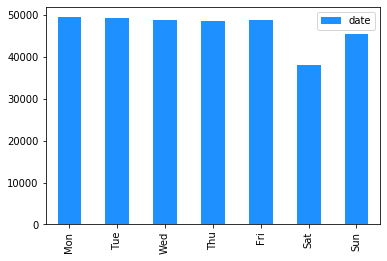

In [43]:
d.plot(kind = 'bar', color = 'dodgerblue')
plt.show()

In [44]:
flights.groupby(dep_date_time.dt.weekday_name).date.count()
# by default it sorts alphabetically

Friday       48732
Monday       49445
Saturday     38033
Sunday       45546
Thursday     48598
Tuesday      49354
Wednesday    48813
Name: date, dtype: int64

In [45]:
flights.groupby(dep_date_time.dt.day_name('es')).date.count()  # I later learned of day_name()
# you need to specify the language to use

Domingo      45546
Jueves       48598
Lunes        49445
Martes       49354
Miércoles    48813
Sábado       38033
Viernes      48732
Name: date, dtype: int64

### Which carriers fly out of which airports?

In [ ]:
# multi-index
flights.groupby(['carrier','origin']).flight.count()

In [ ]:
flights.groupby(['carrier','origin']).flight.count().index

You can make a 'pivot table' by unstacking the multi-index

In [ ]:
flights.groupby(['carrier','origin']).flight.count().unstack()

You can also make a pivot table using the pivot_table method.

In [ ]:
flights.pivot_table('flight',index = 'carrier', columns = 'origin', aggfunc = 'count')

In [ ]:
flights.pivot_table('flight',index = 'carrier', 
                    columns = 'origin', aggfunc = 'count').plot.bar(stacked = True)

In [ ]:
flights.pivot_table('flight',index = 'carrier', 
                    columns = 'origin', aggfunc = 'count').plot.bar()

You can see the top 4 carriers: B6, DL, EV, UA

It appears:
- B6 flies out of JFK the most.
- DL uses JFK and LGA equally
- EV uses EWR heavily
- UA uses EWR heavily as well


I'm curious to see for each of the airports, if one of the carriers will have more 'clout' because it is a bigger user of the airport.

In [ ]:
ewr = flights.loc[flights.origin == 'EWR'].groupby('carrier').flight.count().sort_values(
    ascending = False)
ewr

 I was curious if the proportion of UA and EV flights that are delayed is less than some of the smaller carrier.... maybe these big airlines get higher priority?? 

### Let's look at flights to Los Angeles

In [ ]:
la = flights.loc[flights.dest.isin(['LAX','BUR','ONT','LGB'])]

In [ ]:
la.dest.unique()

In [ ]:
la.dest.value_counts()

In [ ]:
la.carrier.value_counts()

In [ ]:
la.groupby('dest').carrier.value_counts()

B6 (JetBlue) is the only carrier that goes to Burbank or Long Beach. There are no flights from Ontario to New York.

In [ ]:
la.groupby('dest').origin.value_counts()

No direct flights from LaGuardia to Los Angeles. If you want to fly direct to Burbank or Long Beach, you must depart from JFK. 

In [ ]:
la.dep_delay[la.dep_delay.notnull()].astype(int).groupby(la.dest).mean()